# **Estimación de dirección de arribo de fuentes sonoras**



## 1.   En primera instancia, se instalan y se importan las librerias a utilizar.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
import pyroomacoustics as pra
import soundfile as sf
from IPython.display import Audio

## 2. Simulación del entorno acústico

Como primer acercamiento, se lleva a cabo la simulación de una habitación. Para realizar este proceso, se importa audio anecoico.

In [2]:
signal, fs = sf.read("imp.wav") #Importo audio e imprimo su Frecuencia de muestreo
print(f"Frecuencia de muestreo: {fs} Hz")

Frecuencia de muestreo: 48000 Hz


Se plantea las caracteristicas de la habitación, la posición de los microfonos y de la fuente.

In [3]:
room_dim = [100, 100]  # Dimensiones de la sala
mic_distancia = 0.1 # Separación de micrófonos en metros

# Coordenadas de los micrófonos
mic_start = [0.85, 1]  # posición del primer micrófono
mic_positions = np.array([
    [mic_start[0] + i * mic_distancia, mic_start[1]] for i in range(4)
]).T

# Crear sala y agregar fuente
room = pra.ShoeBox(room_dim, fs=44100, max_order=1)
source_position = [50, 50]
room.add_source(source_position, signal=signal)

# Agregar arreglo de micrófonos
room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

room.simulate()

Se crea grafico con posición de los elementos

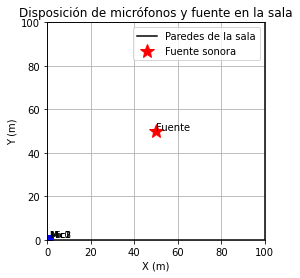

In [4]:

# Calcular posiciones de los micrófonos
mic_positions = np.array([
    [mic_start[0] + i * mic_distancia, mic_start[1]] for i in range(4)
])

# Crear gráfico
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, room_dim[0])
ax.set_ylim(0, room_dim[1])
ax.set_aspect('equal')
ax.grid(True)

# Dibujar sala
ax.plot([0, room_dim[0], room_dim[0], 0, 0],
        [0, 0, room_dim[1], room_dim[1], 0],
        'k-', label='Paredes de la sala')

# Dibujar micrófonos
for i, (x, y) in enumerate(mic_positions):
    ax.plot(x, y, 'bo')
    ax.text(x + 0.05, y + 0.05, f'Mic{i}', fontsize=9)

# Dibujar fuente
ax.plot(source_position[0], source_position[1], 'r*', markersize=15, label='Fuente sonora')
ax.text(source_position[0] + 0.2, source_position[1] + 0.2, 'Fuente', fontsize=10)

# Etiquetas y leyenda
ax.set_title('Disposición de micrófonos y fuente en la sala')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()

plt.show()

Se confirma que el audio se haya simulado correctamente en la habitación, escuchando el audio resultante.

In [5]:
signals = room.mic_array.signals  # señales grabadas por los micrófonos

Audio(signals[0], rate=fs)


#  Estimación de TDOA (Time Difference of Arrival)

## Creo la función que obtendra el TDOA

In [6]:
def estimate_tdoa(sig1, sig2, fs):
    corr = correlate(sig1, sig2, mode='full')
    lag = np.argmax(corr) - (len(sig2) - 1)
    return lag / fs  # tiempo en segundos

Aplico para cada par de microfonos y grafico cada uno de ellos, ademas de la correlación cruzada.

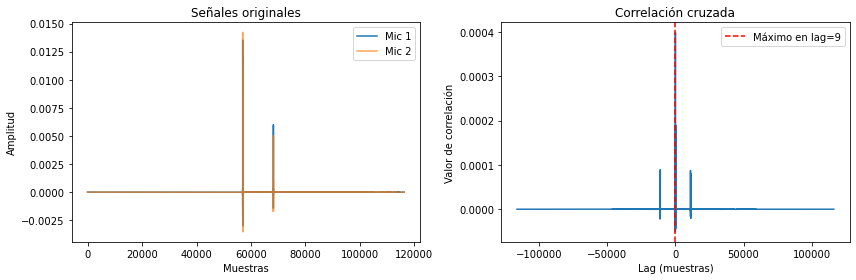

In [7]:
# Usá señales válidas del arreglo, por ejemplo:
sig1 = signals[0]  # señal del micrófono 1
sig2 = signals[1]  # señal del micrófono 2


corr = correlate(sig1, sig2, mode='full')
lag = np.argmax(corr) - (len(sig2) - 1)

# Ahora llamo la función
tdoa = estimate_tdoa(sig1, sig2, fs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(sig1, label='Mic 1')
plt.plot(sig2, label='Mic 2', alpha=0.7)
plt.title('Señales originales')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()

# 2. Graficar la correlación cruzada
lags = np.arange(-len(sig2)+1, len(sig1))
plt.subplot(1, 2, 2)
plt.plot(lags, corr)
plt.axvline(lag, color='r', linestyle='--', label=f'Máximo en lag={lag}')
plt.title('Correlación cruzada')
plt.xlabel('Lag (muestras)')
plt.ylabel('Valor de correlación')
plt.legend()

plt.tight_layout()
plt.show()

Se plantean los valores de TDOA entre cada par de mics.

In [8]:
fs = room.fs
tdoa_01 = estimate_tdoa(signals[0], signals[1], fs)
tdoa_12 = estimate_tdoa(signals[1], signals[2], fs)
tdoa_23 = estimate_tdoa(signals[2], signals[3], fs)

print(tdoa_01*1000,"ms entre MIC1-2")
print(tdoa_12*1000,"ms entre MIC2-3")
print(tdoa_23*1000,"ms entre MIC3-4")

0.20408163265306123 ms entre MIC1-2
0.20408163265306123 ms entre MIC2-3
0.20408163265306123 ms entre MIC3-4


# Cálculo del ángulo de llegada (DOA)

Planteo la función que corresponde a:
\begin{equation}
    \tau = \frac{d \cdot \cos(\theta)}{c}
\end{equation}



In [9]:
c = 343  # velocidad del sonido en m/s

def tdoa_to_angle(tdoa, d, c):
    cos_theta = tdoa * c / d
    cos_theta = np.clip(cos_theta, -1, 1)
    return np.degrees(np.arccos(cos_theta))

Calculo el angulo de llegada que se mide en cada par de microfonos.

In [10]:
angle_01 = tdoa_to_angle(tdoa_01, mic_distancia, c)
angle_12 = tdoa_to_angle(tdoa_12, mic_distancia, c)
angle_23 = tdoa_to_angle(tdoa_23, mic_distancia, c)

Imprimo el angulo luego de promediar entre los distintos resultados obtenidos por los microfonos.

In [11]:
doa_final = np.mean([angle_01, angle_12, angle_23])

print(doa_final)

45.57299599919429
